#Importing Libraries

In [19]:
!pip install category_encoders
!pip install gradio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import category_encoders as ce
import gradio as gr

def handle_NA(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            common_categories = df[col].value_counts().index[:2]
            df[col].fillna(common_categories[0], inplace=True) if len(common_categories) == 1 else df[col].fillna(common_categories[1], inplace=True)
        else:
            df[col] = df[col].interpolate(method='linear')

#Data Loading

In [20]:
train = pd.read_csv("/content/train.csv", header=0)
train_result = train["SalePrice"]
train = train.drop(["SalePrice", 'Id'], axis=1)
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

#Data Preprocessing


In [21]:
handle_NA(pd.DataFrame(train))

for col in train.columns:
    if train[col].dtype == 'object':
        encoder = ce.OrdinalEncoder(cols=[col])
        train = encoder.fit_transform(train)

scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns= train.columns)
train.head()

x_train, x_test, y_train, y_test = train_test_split(train, train_result, test_size=0.2, random_state=42)
#print(x_train.head())

#Clustering for feature selection


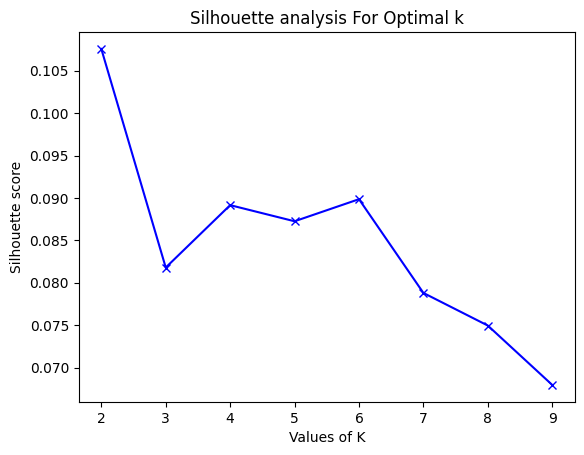

In [22]:
silhouette_avg = []
range_n_clusters = list(range(2, 10))
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init = 80)
    kmeans.fit(x_train.values)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(x_train.values, cluster_labels))

x_train['cluster_label'] = kmeans.labels_
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

x_train = x_train.drop("cluster_label", axis = 1, inplace = False)


optimal_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]

In [23]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init = 100)
kmeans.fit(x_train)
unique_labels, counts = np.unique(kmeans.labels_, return_counts=True)
cluster_counts = dict(zip(unique_labels, counts))
print(cluster_counts)

{0: 650, 1: 518}


In [24]:
labels = kmeans.labels_
#print(len(labels))
#print(x_train.head())

bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(x_train,labels)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
top_features = featureScores.nlargest(10,'Score')
top_features_names = top_features['Specs'].tolist()
print(top_features)
print(top_features_names)

           Specs        Score
18     YearBuilt  1616.250845
58   GarageYrBlt  1450.335652
19  YearRemodAdd  1129.762899
16   OverallQual   896.811574
39     HeatingQC   753.768039
28    Foundation   655.887543
48      FullBath   563.669190
60    GarageCars   499.428217
26     ExterQual   420.446736
61    GarageArea   358.298601
['YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'OverallQual', 'HeatingQC', 'Foundation', 'FullBath', 'GarageCars', 'ExterQual', 'GarageArea']


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


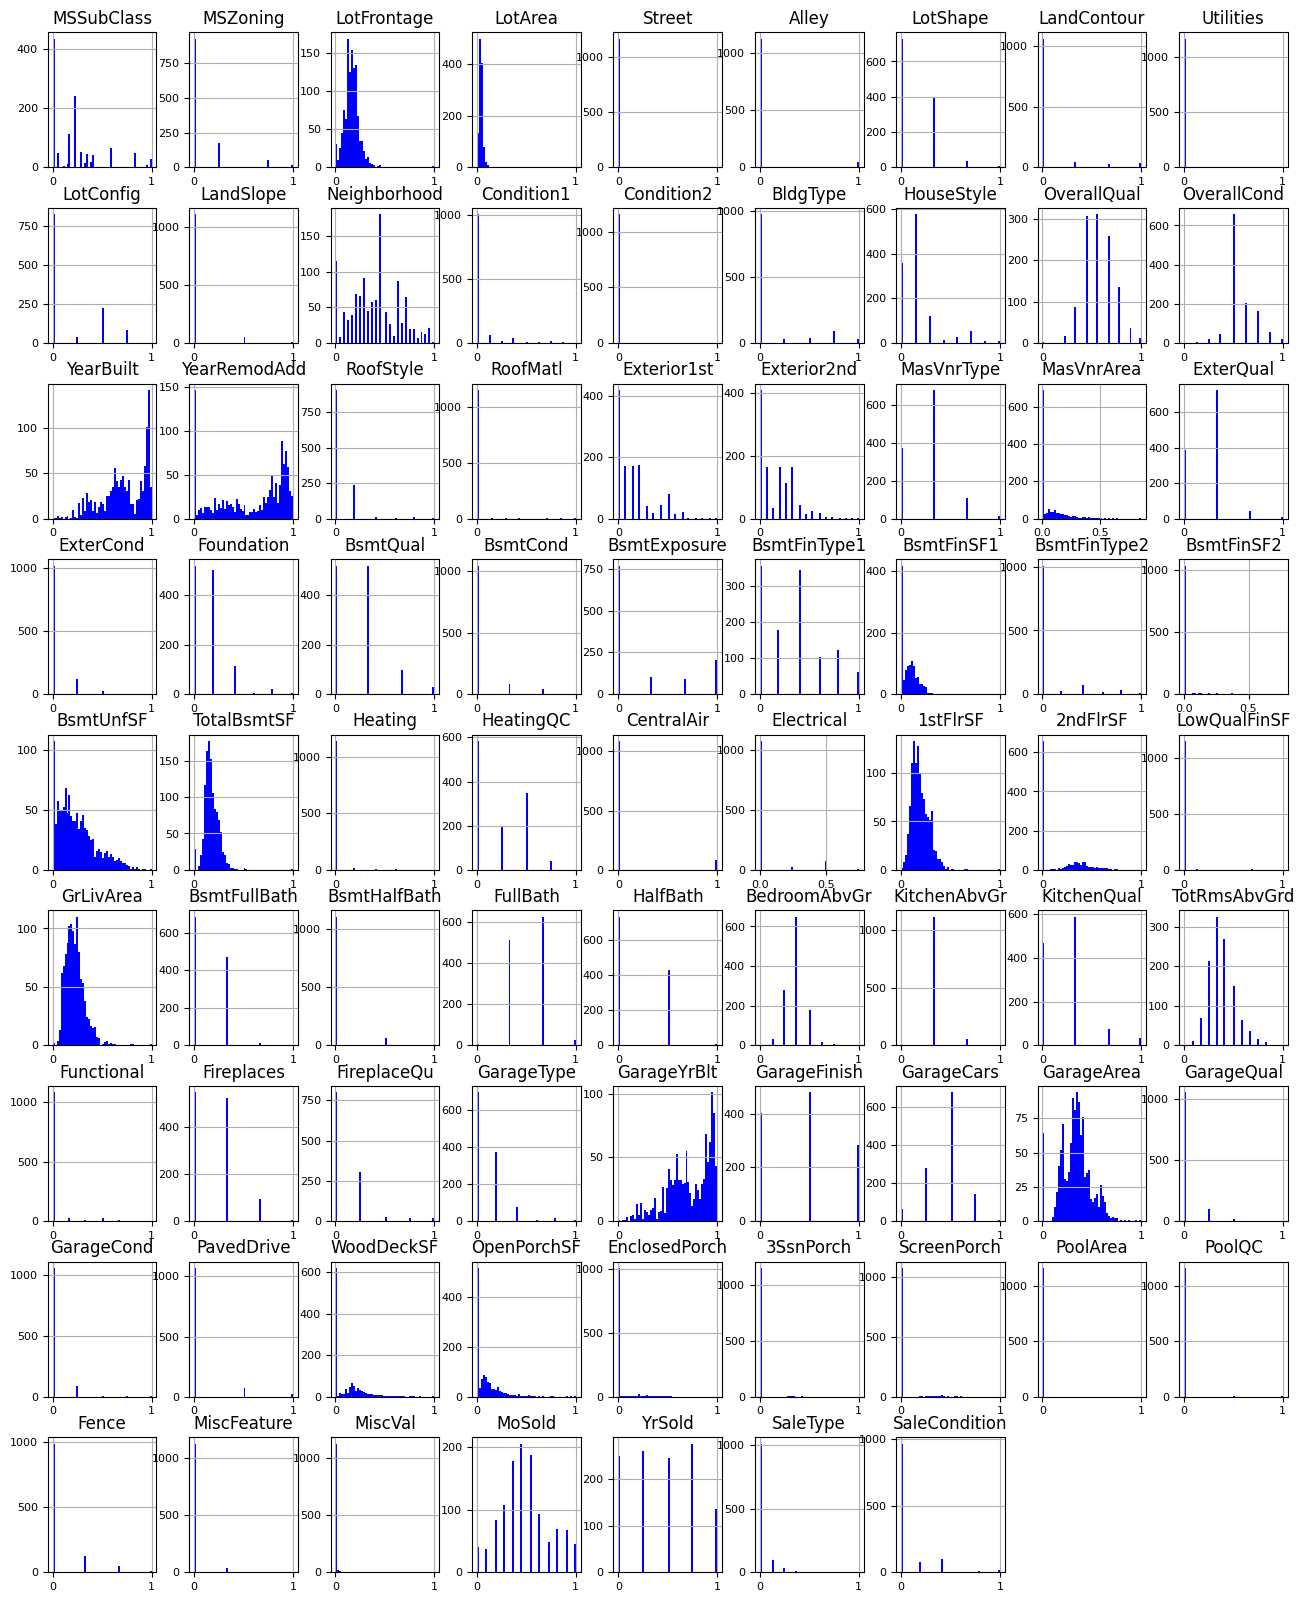

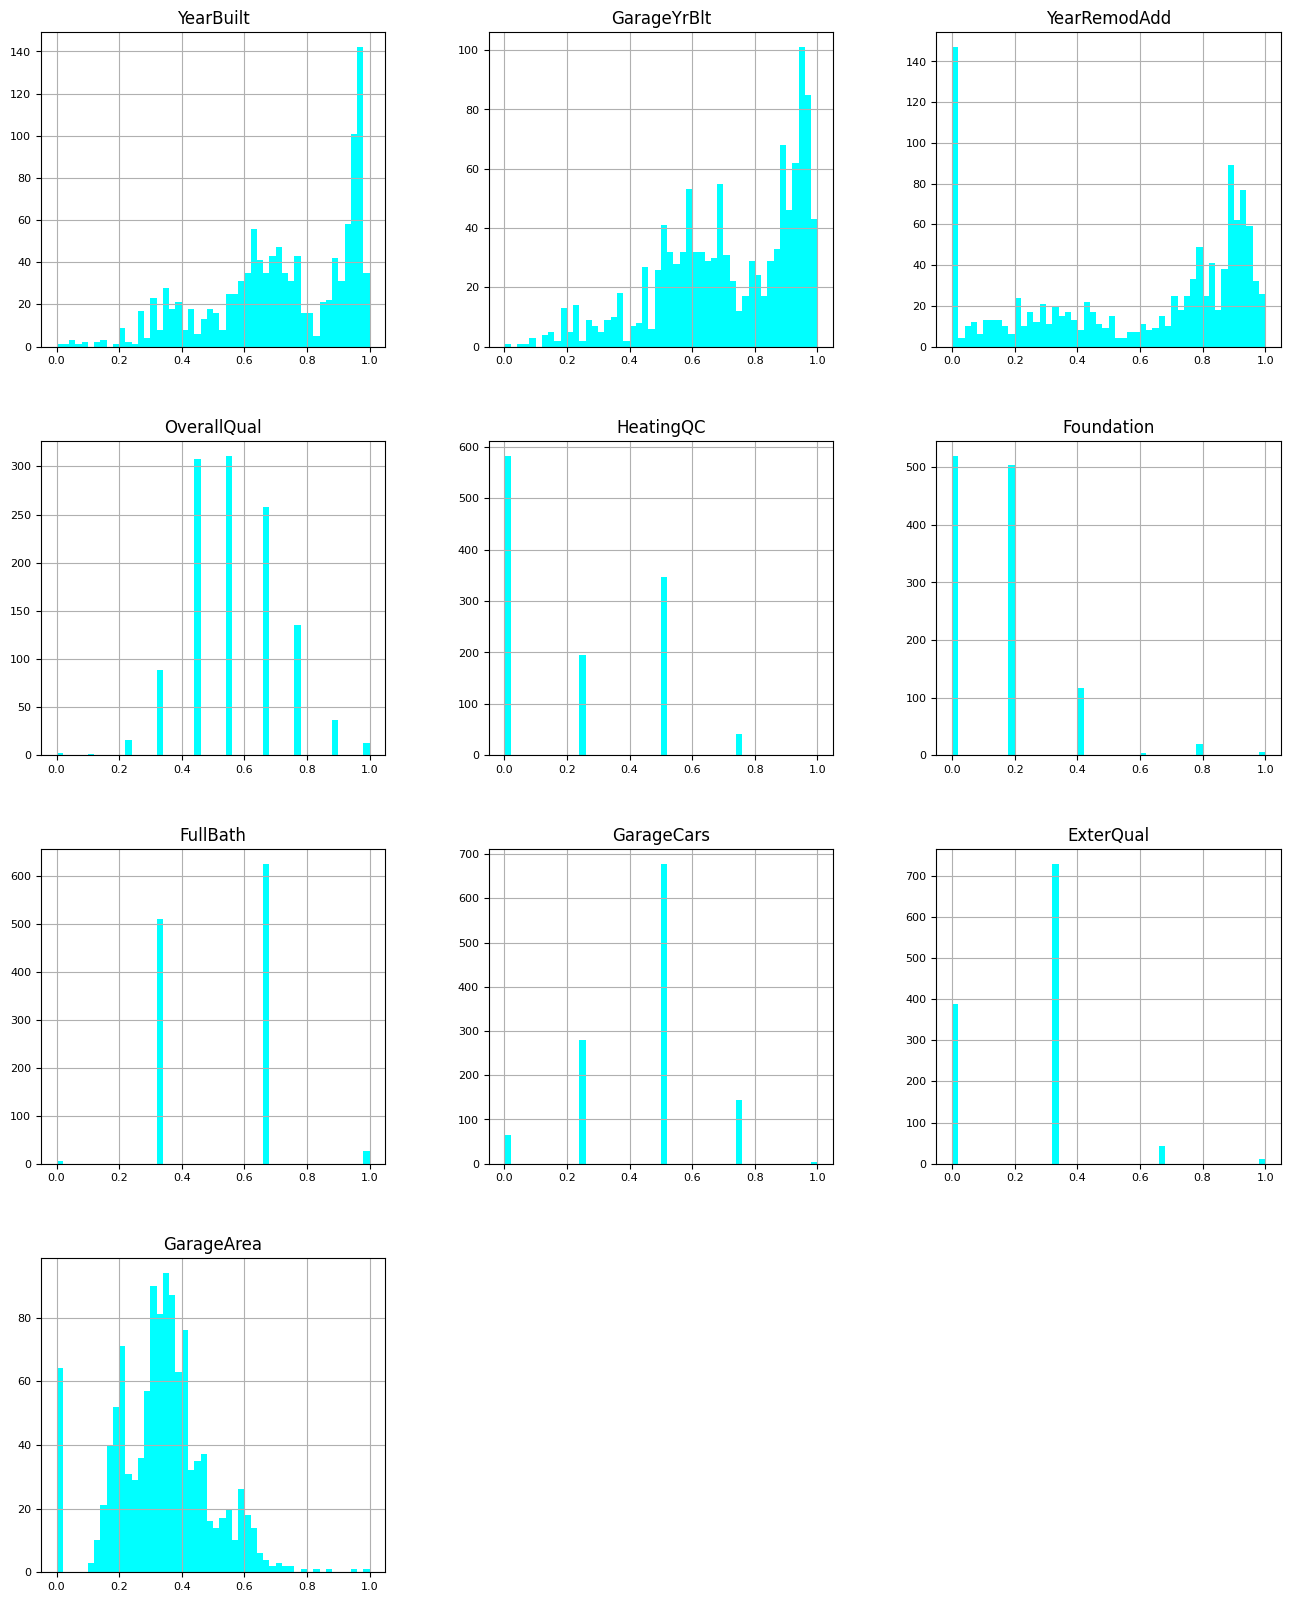

In [26]:
x_train.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='blue')
x_train[top_features_names].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color='cyan')
plt.show()

In [27]:
#print(top_features_names)
x_train = x_train[top_features_names]
x_test = x_test[top_features_names]
x_train

,YearBuilt,GarageYrBlt,YearRemodAdd,OverallQual,HeatingQC,Foundation,FullBath,GarageCars,ExterQual,GarageArea
254,0.615942,0.518182,0.116667,0.444444,0.50,0.2,0.333333,0.25,0.333333,0.207334
1066,0.876812,0.845455,0.733333,0.555556,0.25,0.0,0.666667,0.50,0.000000,0.267983
638,0.275362,0.727273,0.000000,0.444444,0.25,0.2,0.333333,0.00,0.333333,0.000000
799,0.471014,0.354545,0.000000,0.444444,0.00,0.4,0.333333,0.25,0.333333,0.169252
380,0.376812,0.218182,0.000000,0.444444,0.50,0.4,0.666667,0.25,0.333333,0.217207
...,...,...,...,...,...,...,...,...,...,...
1095,0.971014,0.963636,0.933333,0.555556,0.25,0.0,0.666667,0.50,0.000000,0.310296
1130,0.405797,0.736364,0.000000,0.333333,0.50,0.4,0.666667,0.50,0.333333,0.406206
1294,0.601449,0.518182,0.666667,0.444444,0.50,0.2,0.333333,0.50,0.333333,0.403385
860,0.333333,0.227273,0.800000,0.666667,0.25,0.4,0.333333,0.25,0.000000,0.152327


#Use KNN for Prediction


Best value for k:  6 



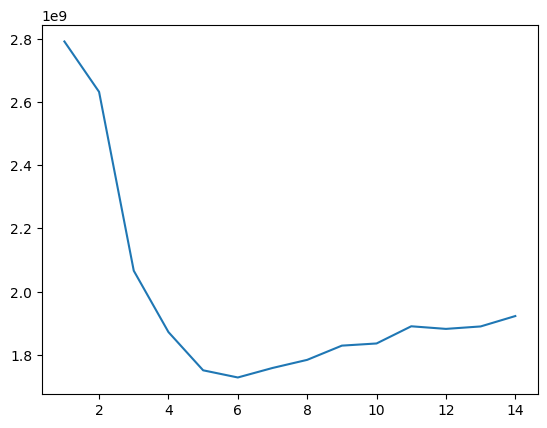

In [28]:
mse = []
num = []
for i in range(1,15):
  num.append(i)


for x in range(1, 15):
    knn_regressor = KNeighborsRegressor(n_neighbors=x)
    knn_regressor.fit(x_train, y_train)
    y_pred = knn_regressor.predict(x_test)
    mserror = mean_squared_error(y_test, y_pred)
    mse.append(mserror)

best_k = num[np.argmin(mse)]
print("Best value for k: ", best_k, "\n")


plt.plot(num, mse)
plt.show()

In [29]:
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
knn_regressor.fit(x_train, y_train)

y_pred = knn_regressor.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(np.sqrt(mse))
print(r2_score(y_test, y_pred))

41567.9135641904
0.7747303841574609


In [30]:
model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)


mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(rmse)

46986.05877175381


# Implementation of Model

In [41]:
import pickle

# Save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))